# NBA Daily Fantasy Sports Analysis
**By: Zack Fort**

**Background** 
<br><br>
This analysis is in accordance with a free weekly Daily Fantasy Sports (DFS) NBA Basketball competition hosted by Yahoo. The competition on 10/27/2023 was utilized as an example in this notebook.<br><br>
This analysis walks through a collection of NBA traditional and advanced statistics from NBA.com's Python API, using forecasting and Machine Learning techniques (stepwise linear regression) to predict each players' fantasy points, and finally an optimization script to produce a lineup to utilize for a given DFS competition based on each player's position, cost to add to the lineup, and predicted fantasy points.

#### Import Needed Libraries
- Pandas and Numpy used for data organization and manipulation <br>
- Pulp utilized for optimization model <br>
- NBA_API utilized for data collection <br>
- Seaborn and Matplotlib used for correlation analysis plot generation <br>
- Statsmodels used for regression modeling <br>
- re used for regular expression text manipulation<br>
- Sci-kit Learn used for modeling and measuring model performance <br>
- mlxtend used for stepwise regression model selection

In [1]:
import pandas as pd
import numpy as np
from pulp import *
import nba_api
from nba_api.stats.endpoints import playergamelogs 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from mlxtend.feature_selection import SequentialFeatureSelector

#### Load in Player Positions and Player DFS Cost datasets
**Cost Dataset:** Dataset manually pulled from Yahoo Daily Fantasy Sports (DFS) website that contains each player's name, position and cost to include that player in the lineup for the DFS contest on 10/27/2023. The data must be manually pulled due to data privacy restraints on scraping the data and no API availability.

In [3]:
#Utilize Sample Data Set saved in GitHub
file4 = ('https://github.com/ZTFisme/Data-Sets/blob/main/NBA_DFS_Cost_10_27.xlsx?raw=true')

cost = pd.read_excel(file4, header=0, names = ['PLAYER','POSITION','COST'])
cost.head()

,PLAYER,POSITION,COST
0,Luka Doncic,PG,57
1,Nikola Jokic,C,56
2,Shai Gilgeous-Alexander,PG,48
3,Jayson Tatum,SF,47
4,LaMelo Ball,PG,44


#### Load Data from NBA.com API
Utilize the playergamelogs NBA.com API endpoint to access up-to-date traditional and advanced player boxscores and load the datasets into dataframes.

In [4]:
seasons = ['2021-22', '2022-23', '2023-24']

advanced_logs = pd.DataFrame()
trad_logs = pd.DataFrame()

for season in seasons:
    print("Gathering data for season: "+season)
    teamlogs = playergamelogs.PlayerGameLogs(season_nullable= season, measure_type_player_game_logs_nullable = nba_api.stats.library.parameters.MeasureTypePlayerGameLogs.advanced)
    logs = teamlogs.get_data_frames()[0]
    advanced_logs = pd.concat([advanced_logs,logs])
    
    tl = playergamelogs.PlayerGameLogs(season_nullable= season)
    trad = tl.get_data_frames()[0]
    trad_logs = pd.concat([trad_logs,trad])
print("Finished")

Gathering data for season: 2021-22
Gathering data for season: 2022-23
Gathering data for season: 2023-24
Finished


### Data Cleansing and Engineering

In [5]:
advanced_logs = advanced_logs[['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'WL', 'MIN', 'OFF_RATING', 'DEF_RATING', 'NET_RATING', 'AST_PCT',
       'AST_TO', 'AST_RATIO', 'REB_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT', 'PACE', 'PIE']].drop_duplicates().reset_index(drop=True)
trad_logs = trad_logs[['SEASON_YEAR', 'PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ID',
       'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK',
       'PFD', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS']].drop_duplicates().reset_index(drop=True)

for i,row in trad_logs.iterrows():
    if '@' in trad_logs.iloc[i]['MATCHUP']:
        trad_logs.at[i,"H_A"] = "Away"
        trad_logs.at[i,"HOME_AWAY"] = 0
        trad_logs.at[i,"OPP"] = trad_logs.iloc[i]['MATCHUP'].split(' @ ')[-1]
    else:
        trad_logs.at[i,"H_A"] = "Home"
        trad_logs.at[i,"HOME_AWAY"] = 1
        trad_logs.at[i,"OPP"] = trad_logs.iloc[i]['MATCHUP'].split(' vs. ')[-1]

data = trad_logs.merge(advanced_logs, how='right', on=['GAME_ID','TEAM_ID','PLAYER_ID'], suffixes=('', '_drop'))
data.drop([col for col in data.columns if 'drop' in col], axis=1, inplace=True)
data = data.dropna().drop_duplicates().reset_index(drop=True).rename(columns = {'NBA_FANTASY_PTS':'FPTS'})
data = data[data['MIN']>=10].reset_index(drop=True).rename(columns = {'TEAM_ABBREVIATION':'TEAM'})
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'].str[:10])
data = data[data['GAME_DATE']<'10/27/2023']
data = data.sort_values(by=['PLAYER_NAME','GAME_DATE']).reset_index(drop=True)

Here is an example of the data that is now sorted to allow for time-series analysis for each individual player. The data also combines traditional and advanced statistics. Prior to being able to model, the data needs to be further manipulated to remove all non-numerical attributes and we must adjust the data to look at historical attributes rather than present-time attributes to predict fantasy point values.

In [6]:
data[data['PLAYER_NAME']=='LeBron James'].head(5)

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,...,NET_RATING,AST_PCT,AST_TO,AST_RATIO,REB_PCT,EFG_PCT,TS_PCT,USG_PCT,PACE,PIE
28717,2021-22,2544,LeBron James,LeBron,1610612747,LAL,Los Angeles Lakers,0022100002,2021-10-19,LAL vs. GSW,...,-2.4,0.250,1.25,14.7,0.141,0.674,0.663,0.322,109.72,0.204
28718,2021-22,2544,LeBron James,LeBron,1610612747,LAL,Los Angeles Lakers,0022100025,2021-10-22,LAL vs. PHX,...,-7.7,0.263,1.00,16.7,0.026,0.583,0.633,0.284,102.48,0.099
28719,2021-22,2544,LeBron James,LeBron,1610612747,LAL,Los Angeles Lakers,0022100040,2021-10-24,LAL vs. MEM,...,-2.5,0.207,2.00,20.7,0.071,0.474,0.478,0.237,103.03,0.096
28720,2021-22,2544,LeBron James,LeBron,1610612747,LAL,Los Angeles Lakers,0022100077,2021-10-29,LAL vs. CLE,...,13.6,0.296,1.14,20.5,0.042,0.477,0.537,0.348,94.23,0.127
28721,2021-22,2544,LeBron James,LeBron,1610612747,LAL,Los Angeles Lakers,0022100093,2021-10-31,LAL vs. HOU,...,8.2,0.364,4.00,26.7,0.091,0.316,0.361,0.253,103.54,0.189


### Find Most Valuable Attributes Correlated with Fantasy Points
Utilizing a correlation matrix to assess the top attributes correlated with fantasy points. I will remove non-numeric values and values that are part of the calculation for fantasy points (points scored, blocks, rebounds, etc.).

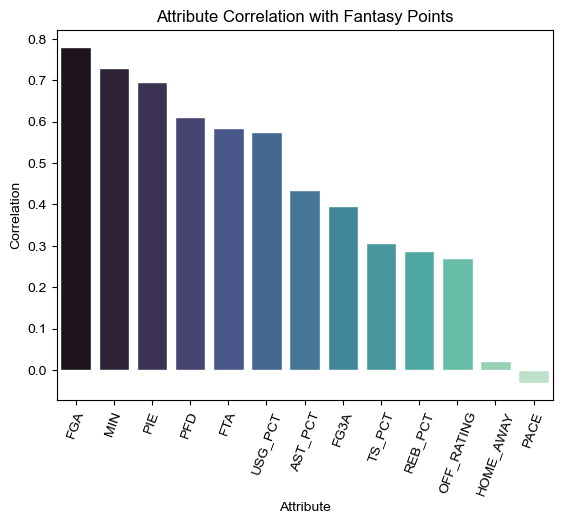

In [7]:
Cor_matrix = data[['MIN','FGA','FG3A','FTA','PFD','HOME_AWAY','OFF_RATING','AST_PCT','REB_PCT','TS_PCT','USG_PCT','PACE','PIE','FPTS']].corr()
cor = Cor_matrix['FPTS'].reset_index().rename(columns={'index':'Attribute','FPTS':'Correlation'}).sort_values(by='Correlation',ascending=False)[1:]

fig, ax = plt.subplots(1)
sns.set_style('ticks')
sns.barplot(x='Attribute',y='Correlation',data=cor, palette='mako')
plt.title('Attribute Correlation with Fantasy Points')
for tick in ax.get_xticklabels():
    tick.set_rotation(70)
plt.show()
plt.close()

In [8]:
#Convert this into a function to call for each attribute to get best average type and k-value

def get_best_forecast(data,field):
    assert field in data.columns
    tab = pd.DataFrame(columns = ['Type','K-Value', 'E', 'MAD', 'MSD'])
    for k in range(2,11):
        forecast = data.groupby('PLAYER_NAME')[field].transform(lambda x: x.rolling(k,k).mean()).shift(1)
        err = np.nanmean(data[field] - forecast)
        forecast = data.groupby('PLAYER_NAME')[field].transform(lambda x: x.rolling(k,k).mean()-err).shift(1)

        MAD = (forecast - data[field]).abs()
        MSD = (forecast - data[field]).abs().pow(2)
        tab.at[k-1, 'Type'] = 'SMA'
        tab.at[k-1, 'K-Value'] = k
        tab.at[k-1, 'E'] = err
        tab.at[k-1, 'MAD'] = np.nanmean(MAD)
        tab.at[k-1, 'MSD'] = np.nanmean(MSD)

        ema = (data.groupby(['PLAYER_NAME'])[field].transform(lambda x: x.ewm(span=k,min_periods=k,adjust=True,ignore_na=True).mean())).shift(1)  
        err = np.nanmean(data[field] - ema)

        ema = (data.groupby(['PLAYER_NAME'])[field].transform(lambda x: x.ewm(span=k,min_periods=k,adjust=True,ignore_na=True).mean() + err)).shift(1)

        ema_MAD = (ema - data[field]).abs()
        ema_MSD = (ema - data[field]).abs().pow(2)
        tab.at[k+50, 'Type'] = 'EMA'
        tab.at[k+50, 'K-Value'] = k
        tab.at[k+50, 'E'] = err
        tab.at[k+50, 'MAD'] = np.nanmean(ema_MAD)
        tab.at[k+50, 'MSD'] = np.nanmean(ema_MSD)
    best = tab.sort_values(by='MAD',ascending=True).reset_index(drop=True)[:1]
    var_name = 'FORECAST_' + field
    
    f_type = best['Type'][0]
    if f_type == 'SMA':
        data[var_name] =  data.groupby('PLAYER_NAME')[field].transform(lambda x: x.rolling(best['K-Value'][0],best['K-Value'][0]).mean() - best['E'][0]).shift(1)
    elif f_type == 'EMA':
        data[var_name] = (data.groupby(['PLAYER_NAME'])[field].transform(lambda x: x.ewm(span=best['K-Value'][0],min_periods=best['K-Value'][0],adjust=True,ignore_na=True).mean() - best['E'][0])).shift(1)

    return data

def apply_best_forecast(data,field):
    assert field in data.columns
    tab = pd.DataFrame(columns = ['Type','K-Value', 'E', 'MAD', 'MSD'])
    for k in range(2,11):
        forecast = data.groupby('PLAYER_NAME')[field].transform(lambda x: x.rolling(k,k).mean()).shift(1)
        err = np.nanmean(data[field] - forecast)
        forecast = data.groupby('PLAYER_NAME')[field].transform(lambda x: x.rolling(k,k).mean()-err).shift(1)

        MAD = (forecast - data[field]).abs()
        MSD = (forecast - data[field]).abs().pow(2)
        tab.at[k-1, 'Type'] = 'SMA'
        tab.at[k-1, 'K-Value'] = k
        tab.at[k-1, 'E'] = err
        tab.at[k-1, 'MAD'] = np.nanmean(MAD)
        tab.at[k-1, 'MSD'] = np.nanmean(MSD)

        ema = (data.groupby(['PLAYER_NAME'])[field].transform(lambda x: x.ewm(span=k,min_periods=k,adjust=True,ignore_na=True).mean())).shift(1)  
        err = np.nanmean(data[field] - ema)

        ema = (data.groupby(['PLAYER_NAME'])[field].transform(lambda x: x.ewm(span=k,min_periods=k,adjust=True,ignore_na=True).mean() + err)).shift(1)

        ema_MAD = (ema - data[field]).abs()
        ema_MSD = (ema - data[field]).abs().pow(2)
        tab.at[k+50, 'Type'] = 'EMA'
        tab.at[k+50, 'K-Value'] = k
        tab.at[k+50, 'E'] = err
        tab.at[k+50, 'MAD'] = np.nanmean(ema_MAD)
        tab.at[k+50, 'MSD'] = np.nanmean(ema_MSD)
    best = tab.sort_values(by='MAD',ascending=True).reset_index(drop=True)[:1]
    var_name = 'FORECAST_' + field
    
    f_type = best['Type'][0]
    if f_type == 'SMA':
        data[var_name] =  data.groupby('PLAYER_NAME')[field].transform(lambda x: x.rolling(best['K-Value'][0],best['K-Value'][0]).mean() - best['E'][0])
    elif f_type == 'EMA':
        data[var_name] = (data.groupby(['PLAYER_NAME'])[field].transform(lambda x: x.ewm(span=best['K-Value'][0],min_periods=best['K-Value'][0],adjust=True,ignore_na=True).mean() - best['E'][0]))
    return data


In [9]:
for field in ['MIN','FGA','PIE','PFD','FTA','USG_PCT','AST_PCT','FG3A','TS_PCT','REB_PCT','FPTS']:
    data = get_best_forecast(data,field)
data = data.dropna().drop_duplicates().reset_index(drop=True)
data[data['PLAYER_NAME']=='LeBron James'].head(5)

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,...,FORECAST_FGA,FORECAST_PIE,FORECAST_PFD,FORECAST_FTA,FORECAST_USG_PCT,FORECAST_AST_PCT,FORECAST_FG3A,FORECAST_TS_PCT,FORECAST_REB_PCT,FORECAST_FPTS
25432,2021-22,2544,LeBron James,LeBron,1610612747,LAL,Los Angeles Lakers,0022100002,2021-10-19,LAL vs. GSW,...,20.432336,0.142905,5.575092,7.157050,0.294736,0.095562,8.985747,0.557565,0.125788,42.424711
25433,2021-22,2544,LeBron James,LeBron,1610612747,LAL,Los Angeles Lakers,0022100304,2021-11-28,LAL vs. DET,...,20.405650,0.140203,5.606067,5.389094,0.289491,0.298559,8.710725,0.582260,0.064659,44.928430
25434,2021-22,2544,LeBron James,LeBron,1610612747,LAL,Los Angeles Lakers,0022100341,2021-12-03,LAL vs. LAC,...,20.319929,0.154270,5.686018,5.919551,0.289782,0.314069,8.769488,0.606596,0.064949,47.894939
25435,2021-22,2544,LeBron James,LeBron,1610612747,LAL,Los Angeles Lakers,0022100365,2021-12-07,LAL vs. BOS,...,20.852613,0.147235,5.748238,5.732972,0.299200,0.303362,8.615420,0.576385,0.084756,47.945835
25436,2021-22,2544,LeBron James,LeBron,1610612747,LAL,Los Angeles Lakers,0022100380,2021-12-09,LAL @ MEM,...,20.486262,0.153678,5.208339,4.997500,0.291097,0.284544,7.905505,0.611321,0.079128,46.239047


In [10]:
X = data[['FORECAST_MIN','FORECAST_FGA','FORECAST_PIE','FORECAST_PFD',
                'FORECAST_FTA','FORECAST_USG_PCT','FORECAST_AST_PCT','FORECAST_FG3A',
                'FORECAST_TS_PCT','FORECAST_REB_PCT']]
y = data['FPTS']

X_train = data[data['GAME_DATE']<'3/1/2023'][['FORECAST_MIN','FORECAST_FGA','FORECAST_PIE','FORECAST_PFD',
                                              'FORECAST_FTA','FORECAST_USG_PCT','FORECAST_AST_PCT','FORECAST_FG3A',
                                              'FORECAST_TS_PCT','FORECAST_REB_PCT']]
y_train = data[data['GAME_DATE']<'3/1/2023']['FPTS']
X_test = data[data['GAME_DATE']>='3/1/2023'][['FORECAST_MIN','FORECAST_FGA','FORECAST_PIE','FORECAST_PFD',
                                              'FORECAST_FTA','FORECAST_USG_PCT','FORECAST_AST_PCT','FORECAST_FG3A',
                                              'FORECAST_TS_PCT','FORECAST_REB_PCT']]
y_test = data[data['GAME_DATE']>='3/1/2023']['FPTS']

### Model Selection
Conducting stepwise regression to limit the number of variables used in modeling. The above correlations indicate some variables may be good indicators, but there also may be some multicollinearity between the variables (field goals attempted and 3-pointers attempted, etc.).

In [11]:
# Build step forward feature selection
sfs1 = SequentialFeatureSelector(linear_model.LinearRegression(),k_features = 5,forward=True,floating=False, scoring='r2',cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X, y)

# Create a dataframe with only the selected features
selected_cols = list(sfs1.k_feature_names_)
 
from statsmodels.stats.outliers_influence import variance_inflation_factor 
  
# Analyze multicollinearity of data
vif_data = pd.DataFrame() 
vif_data["feature"] = X[selected_cols].columns 
vif_data["VIF"] = [variance_inflation_factor(X[selected_cols].values, i) 
                          for i in range(len(X[selected_cols].columns))] 
  
print(vif_data)

            feature        VIF
0      FORECAST_MIN  21.854355
1      FORECAST_FGA  20.746631
2      FORECAST_PFD   7.033864
3  FORECAST_AST_PCT   4.795993
4  FORECAST_REB_PCT   5.021897


In [12]:
#Remove all variables with large VIF
selected_cols.remove('FORECAST_MIN')
selected_cols.remove('FORECAST_FGA')

from statsmodels.stats.outliers_influence import variance_inflation_factor 
  
# Analyze multicollinearity of data after removing variables with high VIF
vif_data = pd.DataFrame() 
vif_data["feature"] = X[selected_cols].columns 
vif_data["VIF"] = [variance_inflation_factor(X[selected_cols].values, i) 
                          for i in range(len(X[selected_cols].columns))] 
  
print(vif_data)

            feature       VIF
0      FORECAST_PFD  4.342890
1  FORECAST_AST_PCT  3.405289
2  FORECAST_REB_PCT  2.860400


All variables now have a VIF less than 5, so we can move forward knowing there isn't strong multicollinearity with these variables for the linear regression model.

In [13]:
# Fit a linear regression model using the selected features on the training data
lr = linear_model.LinearRegression()
lr.fit(X_train[selected_cols], np.array(y_train))
 
# Make predictions using the test set
data['FPTS_ML_PRED'] = lr.predict(X[selected_cols])

#Create a field that blends both predictions
data['AVG_PRED'] = (data['FORECAST_FPTS'] + data['FPTS_ML_PRED']) / 2

#### Determine best predictor

In [14]:
tab = pd.DataFrame(columns = ['Prediction_Type', 'E', 'MAD', 'MSD'])

tab.at[0, 'Prediction_Type'] = 'Forecast'
tab.at[0, 'E'] = np.nanmean(data['FPTS'] - data['FORECAST_FPTS'])
tab.at[0, 'MAD'] = np.nanmean((data['FORECAST_FPTS'] - data['FPTS']).abs())
tab.at[0, 'MSD'] = np.nanmean((data['FORECAST_FPTS'] - data['FPTS']).abs().pow(2))

tab.at[1, 'Prediction_Type'] = 'ML_LR_Reg'
tab.at[1, 'E'] = np.nanmean(data['FPTS'] - data['FPTS_ML_PRED'])
tab.at[1, 'MAD'] = np.nanmean((data['FPTS_ML_PRED'] - data['FPTS']).abs())
tab.at[1, 'MSD'] = np.nanmean((data['FPTS_ML_PRED'] - data['FPTS']).abs().pow(2))

tab.at[2, 'Prediction_Type'] = 'Blended_Avg'
tab.at[2, 'E'] = np.nanmean(data['FPTS'] - data['AVG_PRED'])
tab.at[2, 'MAD'] = np.nanmean((data['AVG_PRED'] - data['FPTS']).abs())
tab.at[2, 'MSD'] = np.nanmean((data['AVG_PRED'] - data['FPTS']).abs().pow(2))

tab

,Prediction_Type,E,MAD,MSD
0,Forecast,0.100647,7.94534,103.131148
1,ML_LR_Reg,0.103227,8.712595,120.220216
2,Blended_Avg,0.101937,8.063035,104.392761


The simple forecast approach achieves relatively good performance while being extremely simple. I will adjust the timing of the prediction to get the latest prediction for each player to be used in the optimization next.

In [15]:
#Change timing of forecast function to get latest prediction
data = apply_best_forecast(data,'FPTS')

#Get Last row to get forecast fpts
last = pd.DataFrame(data.set_index('PLAYER_NAME').groupby(level='PLAYER_NAME').agg(['last']).stack()).reset_index()[['PLAYER_NAME','TEAM','FORECAST_FPTS']]

#Merge latest_prediction dataset with Yahoo DFS Cost data set to combine cost with predictions
pred = last.merge(cost, how = 'inner', left_on = 'PLAYER_NAME', right_on = 'PLAYER').drop(columns='PLAYER').round(2)

Utilize an optimization model with Pulp to generate an optimal lineup based on the prediction, position and cost for each player

In [16]:
df = pred
def pg_id(x):
    if x=='PG':
        return 1
    else:
        return 0
def sg_id(x):
    if x=='SG':
        return 1
    else:
        return 0
def sf_id(x):
    if x=='SF':
        return 1
    else:
        return 0
def pf_id(x):
    if x=='PF':
        return 1
    else:
        return 0
def c_id(x):
    if x=='C':
        return 1
    else:
        return 0

df['PG'] = df['POSITION'].apply(pg_id)
df['SG'] = df['POSITION'].apply(sg_id)
df['SF'] = df['POSITION'].apply(sf_id)
df['PF'] = df['POSITION'].apply(pf_id)
df['C'] = df['POSITION'].apply(c_id)
df['COST'] = [float(i) for i in df['COST']]

#Clean data and convert to list- only look at rows with diet data and not constraint information
df = df.where(df['COST'] > 0)
df = df.dropna()
df = df.values.tolist()

players = [x[0] for x in df]
cost = dict([(x[0], float(x[4])) for x in df])
position = dict([(x[0], x[3]) for x in df])
proj_pts = dict([(x[0], float(x[2])) for x in df])

pg = dict([(x[0], float(x[5])) for x in df])
sg = dict([(x[0], float(x[6])) for x in df])
sf = dict([(x[0], float(x[7])) for x in df])
pf = dict([(x[0], float(x[8])) for x in df])
c = dict([(x[0], float(x[9])) for x in df])

player_vars = LpVariable.dicts("Player", players, cat = "Integer", lowBound= 0, upBound = 1)

    # create the optimization problem framework - maximize points while meeting requirements of maximum cost
prob = LpProblem("NBA_Optimize", LpMaximize)

    #Define objective function for projected points
obj_func = lpSum([proj_pts[i] * player_vars[i] for i in players])
prob += obj_func

    #Number of player choices constraint
constraint_2 = lpSum([player_vars[i] for i in player_vars]) == 8
prob += constraint_2 

    #Cost Constraint
constraint_3 = lpSum([cost[f] * player_vars[f] for f in player_vars]) <= 200.0
prob += constraint_3

    #Position Constraints
    #PG
prob += lpSum([pg[f] * player_vars[f] for f in player_vars]) >= 1
prob += lpSum([pg[f] * player_vars[f] for f in player_vars]) <= 3

    #SG
prob += lpSum([sg[f] * player_vars[f] for f in player_vars]) >= 1
prob += lpSum([sg[f] * player_vars[f] for f in player_vars]) <= 3

    #G
prob += lpSum([(pg[f] * player_vars[f]) + (sg[f] * player_vars[f]) for f in player_vars]) >= 3
prob += lpSum([(pg[f] * player_vars[f]) + (sg[f] * player_vars[f]) for f in player_vars]) <= 4

    #SF
prob += lpSum([sf[f] * player_vars[f] for f in player_vars]) >= 1
prob += lpSum([sf[f] * player_vars[f] for f in player_vars]) <= 3

    #PF
prob += lpSum([pf[f] * player_vars[f] for f in player_vars]) >= 1
prob += lpSum([pf[f] * player_vars[f] for f in player_vars]) <= 3

    #F
prob += lpSum([(sf[f] * player_vars[f]) + (pf[f] * player_vars[f]) for f in player_vars]) >= 3
prob += lpSum([(sf[f] * player_vars[f]) + (pf[f] * player_vars[f]) for f in player_vars]) <= 4

    #C
prob += lpSum([c[f] * player_vars[f] for f in player_vars]) >= 1
prob += lpSum([c[f] * player_vars[f] for f in player_vars]) <= 2

    #Solve the Objective Function
prob.solve()
name_lst = []
import re
for x in prob.variables():
    if x.varValue>0:
        nm = x.name
        name_lst.append(re.sub(r'[_]',' ',nm[7:]))
lineup = pd.DataFrame(name_lst).rename(columns={0:'PLAYER'})
lineup = lineup.merge(pred, how = 'inner', left_on = 'PLAYER', right_on = 'PLAYER_NAME')
lineup = lineup[['PLAYER', 'POSITION', 'TEAM', 'COST', 'FORECAST_FPTS']]
print('The Projected Total Points is: ', round(sum(lineup['FORECAST_FPTS']),2))
print('The optimal lineup based on predictions is: ')
lineup

The Projected Total Points is:  321.83
The optimal lineup based on predictions is: 


,PLAYER,POSITION,TEAM,COST,FORECAST_FPTS
0,Alperen Sengun,C,HOU,26.0,39.79
1,Donovan Mitchell,SG,CLE,37.0,49.74
2,Immanuel Quickley,PG,NYK,14.0,41.64
3,Keldon Johnson,SF,SAS,25.0,37.17
4,Kristaps Porzingis,PF,BOS,33.0,46.84
5,Malcolm Brogdon,PG,POR,12.0,30.43
6,Mikal Bridges,SF,BKN,32.0,40.66
7,Zach Collins,C,SAS,21.0,35.56


### Analyze Predictions

**Top 15 Players based on Predicted Fantasy Points**

In [17]:
pred[['PLAYER_NAME', 'POSITION', 'TEAM', 'COST', 'FORECAST_FPTS']].sort_values('FORECAST_FPTS', ascending = False).reset_index(drop = True).head(15)

,PLAYER_NAME,POSITION,TEAM,COST,FORECAST_FPTS
0,Nikola Jokic,C,DEN,56.0,54.15
1,Shai Gilgeous-Alexander,PG,OKC,48.0,51.00
2,Luka Doncic,PG,DAL,57.0,50.89
3,Donovan Mitchell,SG,CLE,37.0,49.74
4,Jayson Tatum,SF,BOS,47.0,48.06
5,Kristaps Porzingis,PF,BOS,33.0,46.84
6,Domantas Sabonis,C,SAC,41.0,45.77
7,Jimmy Butler,PF,MIA,41.0,45.32
8,Kyrie Irving,SG,DAL,40.0,44.56
9,Paul George,SG,LAC,37.0,44.14


**Top 15 Players Based on Value** <br>
Value is calculated as the Predicted Fantasy Points divided by the Cost to select that player in your lineup

In [18]:
pred['VALUE'] = round(pred['FORECAST_FPTS'] / pred['COST'],2)
pred[['PLAYER_NAME', 'POSITION', 'TEAM', 'COST', 'FORECAST_FPTS', 'VALUE']].sort_values('VALUE', ascending = False).reset_index(drop=True).head(15)

,PLAYER_NAME,POSITION,TEAM,COST,FORECAST_FPTS,VALUE
0,Immanuel Quickley,PG,NYK,14.0,41.64,2.97
1,Theo Maledon,PG,CHA,10.0,28.35,2.84
2,Sandro Mamukelashvili,C,SAS,10.0,28.37,2.84
3,Donte DiVincenzo,SG,NYK,10.0,25.57,2.56
4,Malcolm Brogdon,PG,POR,12.0,30.43,2.54
5,Dennis Smith Jr.,PG,BKN,10.0,25.22,2.52
6,Trendon Watford,PF,POR,10.0,25.01,2.50
7,Quentin Grimes,SG,NYK,11.0,27.44,2.49
8,Dominick Barlow,PF,SAS,10.0,24.23,2.42
9,Tre Mann,PG,OKC,10.0,23.66,2.37


### Assessing Prediction Performance for 10/27/23 Sample

In [21]:
lineup['Actual_FPTS'] = [55.3,70.1,26.2,30.8,40.3,25.9,26.3,36.2]
print('The Actual Total Points of the Optimal Lineup was: ', round(sum(lineup['Actual_FPTS']),2))
lineup

The Actual Total Points of the Optimal Lineup was:  311.1


,PLAYER,POSITION,TEAM,COST,FORECAST_FPTS,Actual_FPTS
0,Alperen Sengun,C,HOU,26.0,39.79,55.3
1,Donovan Mitchell,SG,CLE,37.0,49.74,70.1
2,Immanuel Quickley,PG,NYK,14.0,41.64,26.2
3,Keldon Johnson,SF,SAS,25.0,37.17,30.8
4,Kristaps Porzingis,PF,BOS,33.0,46.84,40.3
5,Malcolm Brogdon,PG,POR,12.0,30.43,25.9
6,Mikal Bridges,SF,BKN,32.0,40.66,26.3
7,Zach Collins,C,SAS,21.0,35.56,36.2


### Summary

Overall, this optimal lineup generator appeared to work well in this example. In Yahoo's free weekly NBA DFS contest, this viable lineup would have placed **1,533th out of 17,472** lineups submitted *(top 9%)*. 

In summary, this notebook pulled NBA data from the past few seasons, assessed both simple forecasting and Machine Learning predictions, and then utilized the forecasting approach against the respective cost of each player to generate an optimized lineup. The lineup suggested would have performed well, generating 311 fantasy points for Yahoo's 10/27 NBA DFS contest.